In [20]:
import pathlib
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import random

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [22]:
batch_size = 16

In [23]:
# load the images and masks
dir_images_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/images')
dir_masks_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/masks')
dir_images_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/images')
dir_masks_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/masks')

In [24]:
train_ids = [f.stem for f in dir_images_train.glob("*.jpg")]
test_ids = [f.stem for f in dir_images_test.glob("*.jpg")]

In [25]:
#train_ids = train_ids[:batch_size*10]#*100
#test_ids = test_ids[:batch_size*20]

In [26]:
len(train_ids), len(test_ids)

(762, 182)

In [27]:
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            mask_dir (pathlib.Path): Directory with all the masks.
            pca_data (pd.DataFrame): DataFrame containing PCA features.
            ids (list): List of image/mask IDs (without extensions).
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.jpg").convert("RGB"))
        
        mask = np.array(Image.open(self.mask_dir / f"{name}.jpg").convert("L")) / 255
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)

        return image, mask


In [28]:
# Create datasets with transformations
dataset_train = KvasirSegDataset(dir_images_train, dir_masks_train, train_ids)
dataset_test = KvasirSegDataset(dir_images_test, dir_masks_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [29]:
for images, masks in train_loader:
    print(images[0].shape)
    print(images[0])
    break

torch.Size([128, 128, 3])
tensor([[[0, 2, 2],
         [0, 2, 2],
         [0, 1, 0],
         ...,
         [1, 0, 0],
         [0, 0, 2],
         [0, 0, 2]],

        [[0, 2, 2],
         [0, 1, 2],
         [0, 1, 0],
         ...,
         [1, 0, 0],
         [0, 0, 2],
         [0, 0, 2]],

        [[0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         ...,
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [1, 0, 0],
         [3, 0, 0],
         [3, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 2],
         [1, 0, 2]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 2],
         [1, 0, 2]]], dtype=torch.uint8)


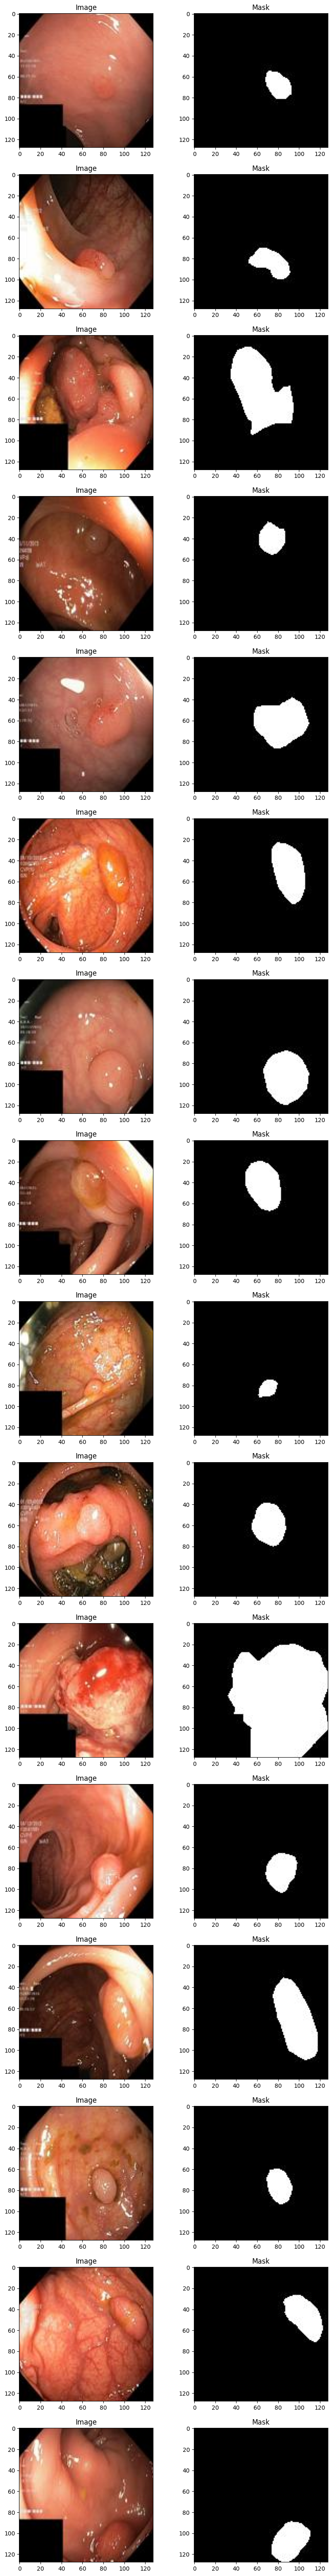

In [30]:
# plot the images and masks
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(masks[i], cmap='gray')
        axs[i, 1].set_title("Mask")
    plt.show()
# Get a batch of images and masks
for images, masks in train_loader:
    plot_images_and_masks(images, masks)
    break

In [31]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final Convolution
        self.final_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(torch.nn.functional.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(torch.nn.functional.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(torch.nn.functional.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(torch.nn.functional.max_pool2d(enc4, kernel_size=2))

        # Decoder
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))

        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        # Final output
        return self.final_conv(dec1)
    
# Instantiate the model
model = UNet()
# move model to device
model.to(device)
print(f"Model is on: {next(model.parameters()).device}")

Model is on: cuda:0


In [32]:
# test model with a random input
#x = torch.randn(512).to(device)
x = torch.rand(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[[[0.0692, 0.0725, 0.0747,  ..., 0.0791, 0.0780, 0.0787],
          [0.0665, 0.0723, 0.0741,  ..., 0.0791, 0.0775, 0.0808],
          [0.0690, 0.0742, 0.0718,  ..., 0.0728, 0.0762, 0.0836],
          ...,
          [0.0691, 0.0759, 0.0724,  ..., 0.0767, 0.0758, 0.0814],
          [0.0684, 0.0681, 0.0721,  ..., 0.0683, 0.0743, 0.0724],
          [0.0681, 0.0696, 0.0716,  ..., 0.0673, 0.0695, 0.0730]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


In [33]:
y.shape

torch.Size([1, 1, 128, 128])

In [34]:
# test model with the first image from the train dataset
for i, (image, mask) in enumerate(train_loader):
    image = image.to(device).permute(0, 3, 1, 2)/255
    y = model(image)
    print(y.int())
    break

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
         

In [35]:
image[0].shape

torch.Size([3, 128, 128])

In [36]:
mask[0].shape

torch.Size([128, 128])

In [37]:
mask[0].max(), mask[0].min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [38]:
# train u network, use IOU
def iou_loss(pred, target, smooth=0):
    intersection = torch.minimum(pred, target).sum(dim=(1, 2))
    union = torch.maximum(pred, target).sum(dim=(1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou.mean()

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
num_epochs = 200

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, masks in train_loader:
        images = (images.permute(0, 3, 1, 2)/255).to(device)
        masks = masks.unsqueeze(1).to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = iou_loss(outputs, masks)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

Epoch [1/200], Loss: 0.8834
Epoch [2/200], Loss: 0.8270
Epoch [3/200], Loss: 0.8199
Epoch [4/200], Loss: 0.8070
Epoch [5/200], Loss: 0.7993
Epoch [6/200], Loss: 0.7986
Epoch [7/200], Loss: 0.7946
Epoch [8/200], Loss: 0.7930
Epoch [9/200], Loss: 0.7933
Epoch [10/200], Loss: 0.7947
Epoch [11/200], Loss: 0.7924
Epoch [12/200], Loss: 0.7891
Epoch [13/200], Loss: 0.7824
Epoch [14/200], Loss: 0.7829
Epoch [15/200], Loss: 0.7803
Epoch [16/200], Loss: 0.7761
Epoch [17/200], Loss: 0.7672
Epoch [18/200], Loss: 0.7616
Epoch [19/200], Loss: 0.7639
Epoch [20/200], Loss: 0.7585
Epoch [21/200], Loss: 0.7595
Epoch [22/200], Loss: 0.7556
Epoch [23/200], Loss: 0.7490
Epoch [24/200], Loss: 0.7468
Epoch [25/200], Loss: 0.7431
Epoch [26/200], Loss: 0.7423
Epoch [27/200], Loss: 0.7381
Epoch [28/200], Loss: 0.7303
Epoch [29/200], Loss: 0.7367
Epoch [30/200], Loss: 0.7271
Epoch [31/200], Loss: 0.7192
Epoch [32/200], Loss: 0.7252
Epoch [33/200], Loss: 0.7199
Epoch [34/200], Loss: 0.7162
Epoch [35/200], Loss: 0

In [39]:
torch.cuda.empty_cache()

In [40]:
# remove from the device all but except the models
model.cpu()
device = "cpu"

In [41]:
# test the model on the test dataset and calculate the mean iou
model.eval()
ious = torch.zeros(len(test_loader)).to(device)
masks_list = []
ious_list = []
images_list_mem = []
target_masks_list = []

for i, (images, target_masks) in enumerate(test_loader):
    if i < 36:
        images_list_mem.append(images)
        target_masks_list.append(target_masks)
    
    target_masks = target_masks.detach().numpy()
    images = images.to(device).permute(0, 3, 1, 2) / 255
    masks = model(images)
    if i < 36:
        masks_list.append(masks)

    masks = masks.detach().numpy()
    # 1. Compute Intersection over Union
    intersection = np.minimum(masks, target_masks).sum()
    union = np.maximum(masks, target_masks).sum()
    iou = intersection / union
    
    ious_list.append(iou)

In [42]:
# calculate the mean iou and the std of the ious
ious = torch.tensor(ious_list)
ious.mean(), ious.std(), ious.max(), ious.min(), ious.median()

(tensor(0.3767, dtype=torch.float64),
 tensor(0.2100, dtype=torch.float64),
 tensor(0.8843, dtype=torch.float64),
 tensor(7.7526e-05, dtype=torch.float64),
 tensor(0.3719, dtype=torch.float64))

In [43]:
masks_list[0][0].shape

torch.Size([1, 128, 128])

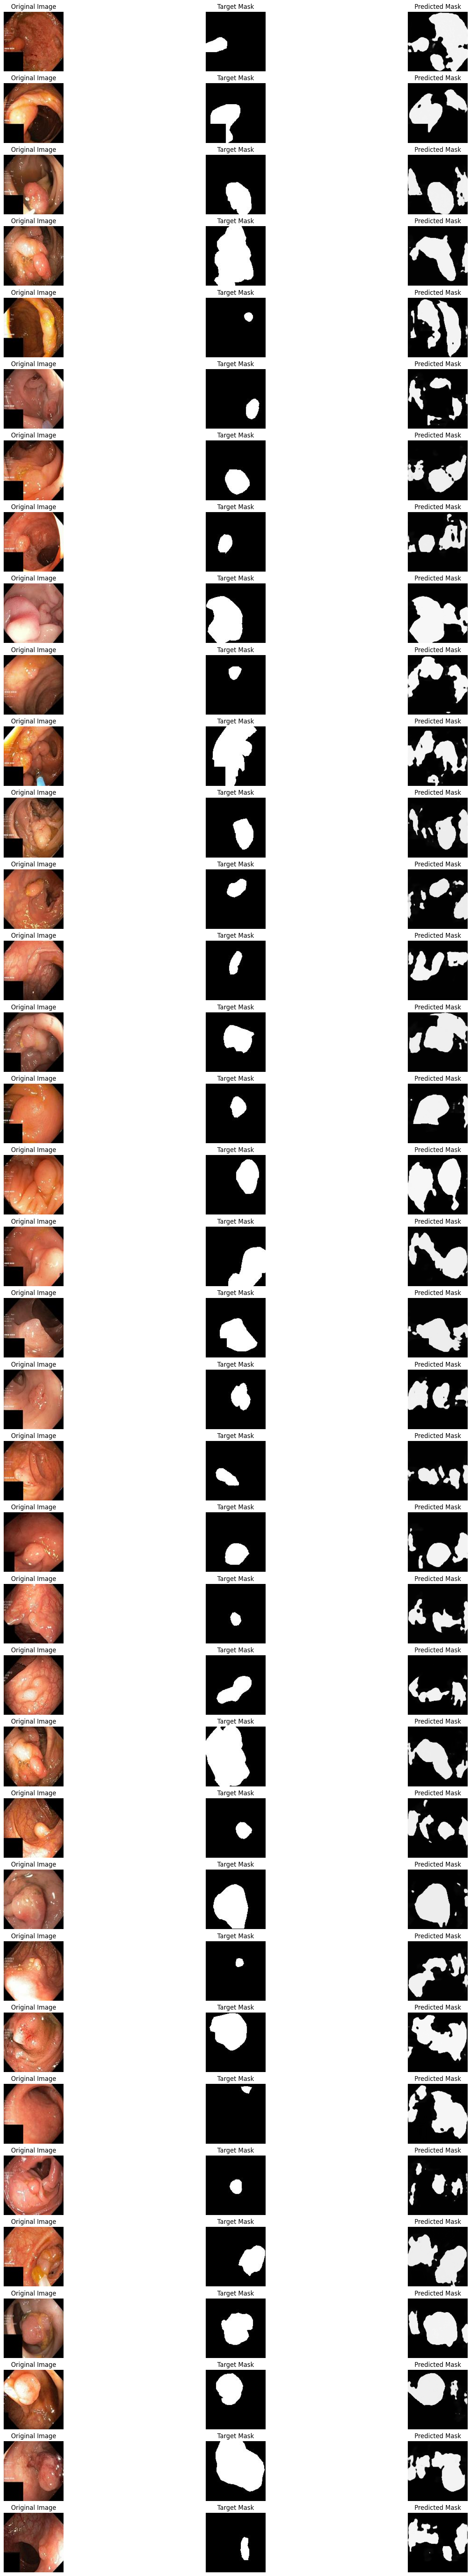

In [44]:
#visualize original images, prompt points, target masks and predicted masks of the test images
plt.figure(figsize=(20, 90))
# add title to the plot
for i in range(36):
    plt.subplot(36, 3, 3 * i + 1)
    plt.imshow(images_list_mem[i].squeeze(0))
    plt.title(f"Original Image")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 2)
    plt.imshow(target_masks_list[i][0], cmap='gray')
    plt.title("Target Mask")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 3)
    plt.imshow(masks_list[i][0][0].detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
plt.show()

In [45]:
# save the model
torch.save(model.state_dict(), "base_line_segmentator.pth")